<font color="lightblue">

**GERMON Paul et MARTIN Hugo**

</font>

# Apprenez une heuristique pour le Go

Dans ce TP noté, vous devrez déployer des methodes d'apprentissage automatique permettant d'évaluer la qualité de plateaux de GO.

Pour cela, vous disposerez de 41563 exemples de plateau de Go, tous générés par gnugo après quelques coups contre lui même avec un niveau de difficulté de 0. Par chaque plateau, nous avons lancé 100 matchs de gnugo contre lui même, toujours avec un niveau 0, et compté le nombre de victoires de noir et de blanc depuis ce plateau.

A noter, chaque "rollout" (un rollout et un déroulement possible du match depuis le plateau de référence) correspond à des mouvements choisis aléatoirement parmis les 10 meilleurs mouvements possibles, en biasant le choix aléatoire par la qualité prédite du mouvement par gnugo (les meilleurs mouvements ont une plus forte probabilité d'être tirés).

Les données dont vous disposez sont brutes. Ce sera à vous de proposer un format adéquat pour utiliser ces données en entrée de votre réseau neuronal. 

## Comment sera évalué votre modèle ?

Nous vous fournirons 6h avant la date de rendu un nouveau fichier contenant 1000 nouveaux exemples, qui ne contiendront pas les champs `black_wins`, `white_wins`, `black_points` et `white_points`. Vous devrez laisser, dans votre dépot de projet un fichier texte nommé `my_predictions.txt` ayant une prédiction par ligne (un simple flottant) qui donnera, dans le même ordre de la liste des exemples les scores que vous prédisez pour chacune des entrées du fichier que nous vous aurons donné. Il faudra laisser, dans votre feuille notebook (voir tout en dessous) la cellule Python qui aura créé ce fichier, pour que l'on puisse éventuellement refaire vos prédictions.

Bien entendu, vous nous rendrez également votre feuille jupyter **sous deux formats**, à la fois le fichier `.ipynb` et le fichier `.html` nous permettant de lire ce que vous avez fait, sans forcément relancer la feuille. Nous prendrons en compte les résultats obtenus sur les prédictions mais aussi le contenu de vos notebooks jupyter.

### Comment sera noté ce TP ?

Il s'agit d'un TP noté, donc il ne faudra pas y passer trop de temps. Nous attendons des prédictions correctes mais surtout des choix justifiés dans la feuille. Votre feuille notebook sera le plus important pour la notation (n'hésitez pas à mettre des cellules de texte pour expliquer pourquoi vous avez été amenés à faire certains choix). Ainsi, il serait bien d'avoir, par exemple, les données (graphiques ou autre) qui permettent de comprendre comment vous avez évité l'overfitting.

Le fichier de vos prédiction sera évalué en se basant sur la qualité de vos prédictions. Nous mesurerons par exemple le nombre d'exemples dont votre prédiction donnera la bonne valeur à 5%, 10%, 20%, 35%, 50% pour estimer sa qualité.


## Mise en route !

Voyons  comment lire les données


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import gzip, os.path
import json
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization
import tensorflow.keras.optimizers as optimizers

In [ ]:
# Import du fichier d'exemples

def get_raw_data_go(data_to_predict, output):
    ''' Returns the set of samples from the local file or download it if it does not exists'''


    raw_samples_file = output

    if not os.path.isfile(raw_samples_file):
        print("File", raw_samples_file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve (data_to_predict, output)
        print(" Done")

    with gzip.open(output) as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

# Fonction qui permet de télécharger le fichier file depuis l'url
def download(url,file):
  import os.path
  if not os.path.isfile(file):
        print("File", file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve (url, file)
        print(" Done")


data = get_raw_data_go("https://www.labri.fr/perso/lsimon/ia-inge2/samples-9x9.json.gz","samples-9x9.json.gz")
print("We have", len(data),"examples")

File samples-9x9.json.gz not found, I am downloading it... Done
We have 41563 examples


## Compréhension des données de chaque entrée

Voici une description de chaque exemple

In [ ]:
def summary_of_example(data, sample_nb):
    ''' Gives you some insights about a sample number'''
    sample = data[sample_nb]
    print("Sample", sample_nb)
    print()
    print("Données brutes en format JSON:", sample)
    print()
    print("The sample was obtained after", sample["depth"], "moves")
    print("The successive moves were", sample["list_of_moves"])
    print("After these moves and all the captures, there was black stones at the following position", sample["black_stones"])
    print("After these moves and all the captures, there was white stones at the following position", sample["white_stones"])
    print("Number of rollouts (gnugo games played against itself from this position):", sample["rollouts"])
    print("Over these", sample["rollouts"], "games, black won", sample["black_wins"], "times with", sample["black_points"], "total points over all these winning games")
    print("Over these", sample["rollouts"], "games, white won", sample["white_wins"], "times with", sample["white_points"], "total points over all these winning games")

summary_of_example(data,10)

Sample 10

Données brutes en format JSON: {'depth': 8, 'list_of_moves': ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7'], 'black_stones': ['B7', 'C6', 'E5', 'C3'], 'white_stones': ['C8', 'E7', 'H7', 'G3'], 'rollouts': 100, 'black_wins': 60, 'black_points': 876.0, 'white_wins': 40, 'white_points': 378.0}

The sample was obtained after 8 moves
The successive moves were ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7']
After these moves and all the captures, there was black stones at the following position ['B7', 'C6', 'E5', 'C3']
After these moves and all the captures, there was white stones at the following position ['C8', 'E7', 'H7', 'G3']
Number of rollouts (gnugo games played against itself from this position): 100
Over these 100 games, black won 60 times with 876.0 total points over all these winning games
Over these 100 games, white won 40 times with 378.0 total points over all these winning games


## Données en entrée et en sortie de votre modèle final

Même si en interne, votre modèle va manipuler des tenseurs en numpy, vous devrez construire une boite noire qui prendra en entrée les coordonnées des pierres noires et blanches et donnera le pourcentage de chance pour noir de gagner depuis cette position. 

Ainsi, pour l'exemple `i` :
- Vous prendez en entree `data[i]["black_stones"]` et `data[i]["white_stones"]`
- Vous devrez prédire simplement `data[i]["black_wins"]/data[i]["rollouts"]`

Encore une fois, **attention** : en interne, il faudra absolument construire vos données formattées en matrices numpy pour faire votre entrainement. On vous demande juste ici d'écrire comment vous faites ces transformations, pour comprendre ce que vous avez décidé de mettre en entrée du réseau.

Voici le modèle de la fonction qui pourra être appelée, au final :


In [ ]:
# Ainsi, pour le rendu, en admettant que newdata soit le fichier json contenant les nouvelles données que 
# l'on vous donnera 24h avant la fin, vous pourrez construire le fichier resultat ainsi

def create_result_file(newdata):
    ''' Exemple de méthode permettant de générer le fichier de resultats demandés. '''
    resultat  = [position_predict(d["black_stones"], d["white_stones"]) for d in newdata]
    with open("my_predictions.txt", "w") as f:
         for p in resultat:
            f.write(str(p)+"\n")

In [ ]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""

    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    acc = history.history['accuracy']

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

The CDF curve shows that black has more chances to win, globally


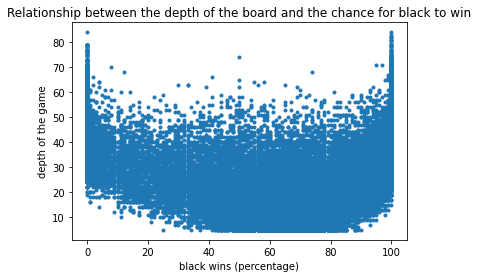

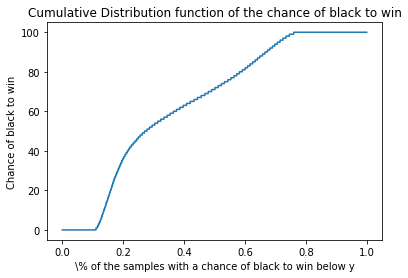

In [ ]:
plt.title("Relationship between the depth of the board and the chance for black to win")
plt.plot([sample["black_wins"] for sample in data],[sample["depth"] for sample in data], '.')
plt.xlabel("black wins (percentage)")
plt.ylabel("depth of the game")


# Cumulative Distribution function of the chance of black to win
cdf_wins = sorted([sample["black_wins"] for sample in data])
plt.figure()
plt.plot([x/len(cdf_wins) for x in range(len(cdf_wins))], cdf_wins)
plt.title("Cumulative Distribution function of the chance of black to win")
plt.xlabel("\% of the samples with a chance of black to win below y")
plt.ylabel("Chance of black to win")
print("The CDF curve shows that black has more chances to win, globally")

# First steps: transform all the data into numpy arrays to feed your neural network

Advices:
- do not use only a 9x9 matrix as input. Use at least two planes to encode the board. One plane for black and one plane for white (typically with a 1 if there is a black stone for the first plane and with a 1 if there is a white stone for the second plane). The dimension of an input should be at least `[9,9,2]`.
- consider to enrich your dataset with all symmetries and rotations. You should be able to multiply the number of samples to consider: any rotation of the board should have the same score, right?
- what should happen on the score if you switch the colors? To know which player has to play next, you can check, for a sample, the parity of the length of the list `data[i]["list_of_moves"]` (an odd length list would mean that white is the next player. An even length list means that black has to play).
- work on enlarging and preparing your data only once. Once all you input data is setup as a big Numpy matrix, you may want to save it for speeding up everything. You can use, for instance `numpy.rot90()` and `numpy.flipud()` to generate all the symmetries



In [ ]:
# Convertit les moves en coordonnées
def name_to_coord(s):
    assert s != "PASS"
    indexLetters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'J':8}

    col = indexLetters[s[0]]
    lin = int(s[1:]) - 1
    return col, lin

In [ ]:
# Preprocess la data et remplit les structures X et Y de données et labels
def fill_data_struct(data, board_size):
    N_EXAMPLES = len(data)
    
    # *8 pour le nombre de symétries et rotations possibles
    X = np.zeros([N_EXAMPLES * 8, board_size, board_size, 3], dtype = int)
    Y = np.zeros([N_EXAMPLES * 8, 3], dtype = float)
    #Y = np.zeros(N_EXAMPLES * 8, dtype = float)

    # Construction de X : un plateau pour les blancs et un pour les noirs
    for i in range(N_EXAMPLES):

        # On ajoute les pierres noires dans le plan 0 de X via leurs coordonnées
        for black in data[i]['black_stones']:
            (col, lin) = name_to_coord(black)
            X[i][col][lin][0] = 1
            
        # Idem pour les pierres blanches dans le plan 1 de X
        for white in data[i]['white_stones']:
            (col, lin) = name_to_coord(white)
            X[i][col][lin][1] = 1
            
        player = 0 if len(data[i]["list_of_moves"]) % 2 == 0 else 1
        
        for x in range(board_size):
            for y in range(board_size):
                X[i][col][lin][2] = player
            
        
        # On ajoute les rotations de 90° des plateaux
        for k in range(1, 4):
            X[i + N_EXAMPLES * k] = np.rot90(X[i], k, axes=(0, 1))

        # Puis les symétries horizontales des rotations
        for k in range(0, 4):
            X[i + N_EXAMPLES * (k + 4)] = np.flipud(X[i + N_EXAMPLES * k])


        # On remplit Y : les rotations/symétries d'un plateau ont le même label
        b_wins = data[i]['black_wins'] / data[i]['rollouts']
        w_wins = data[i]['white_wins'] / data[i]['rollouts']
        
        for k in range(8):
            #Y[i + N_EXAMPLES * k] = b_wins
            Y[i + N_EXAMPLES * k][0] = b_wins
            Y[i + N_EXAMPLES * k][1] = w_wins
    
    return X, Y

<font color="lightblue">

La matrice X correspond donc aux données d'entrée et est sous la forme (N\*8,9,9,2) tandis que la matrice Y correspond aux probabilités de victoire en tant que joueur noir et joueur blanc et est sous la forme (N\*8,) 

Pour chaque plateau dans le dataset nous avons ajouté ses rotations de 0° (plateau de base), 90°, 180° et 270° ainsi que les symétries horizontales de ces rotations.
,
Pour chaque plateau du dataset nous ajoutons donc 7 variations de ce plateau. Cela nous permet d'augmenter notre jeu de données sans modifier la probabilité de victoire des noirs ou des blancs.

</font>

In [ ]:
board_size = 9

X, Y = fill_data_struct(data, board_size)

# Séparation des données d'entrée en un training set et un test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, shuffle=True)

In [ ]:
print(f"X.shape = {X.shape}")
print(f"Y.shape = {Y.shape}")
print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"Y_train.shape = {Y_train.shape}")
print(f"Y_test.shape = {Y_test.shape}")

X.shape = (332504, 9, 9, 2)
Y.shape = (332504, 2)
X_train.shape = (266003, 9, 9, 2)
X_test.shape = (66501, 9, 9, 2)
Y_train.shape = (266003, 2)
Y_test.shape = (66501, 2)


# Second steps: build your neural network and train it

Don't forget to check overfitting, ...

*advices* :
- you need to test Dense and Conv2D layers (the best models may contain convolution layers=
- if you use convolution layers, be sure not to downsize your board. Applying a filter should keep the original size of the board (9x9), otherwise you would somehow forget the stones on the borders
- you will use like 33% of your input sample for validation. However, the final goal is to score new data that will be given in addition to the actual data. So, you should use the 33% splitting rule to set up your network architecture and, once you fixed it, you should train your final model on the whole set of data, crossing your fingers that it will generalize well.
- Warning: if you launch the fit function from keras more than once, it will not reset the weights and the biases of your neural network. It's good news because you can add more and more epochs to your model, but be careful about the training/test sets: each time you call fit() with validation_split set up to something like 0.33, it will choose a **new** partition of the samples. So you are breaking your validation/training partition! We advice you to use the `sklearn.model_selection.train_test_split()` method to split the set of examples just once and then use the parameter `validation_data` in the call for `fit()`.  Thus you will be able to call it multiple time.


In [ ]:
model_prior = Sequential()
model_prior.add(Conv2D(filters = 64,
                        input_shape = (9,9,2),
                        activation = 'relu',
                        kernel_size = (5,5),
                        padding = 'same',
                        data_format = 'channels_last'))
model_prior.add(BatchNormalization(axis = 3))
model_prior.add(Conv2D(filters = 64,
                        activation = 'relu',
                        kernel_size = (5,5),
                        padding = 'same',
                        data_format = 'channels_last'))
model_prior.add(BatchNormalization(axis = 3))
model_prior.add(Conv2D(filters = 64,
                        activation = 'relu',
                        kernel_size = (5,5),
                        padding = 'same',
                        data_format = 'channels_last'))
model_prior.add(BatchNormalization(axis = 3))
model_prior.add(Flatten(data_format = 'channels_last'))
model_prior.add(Dropout(rate = 0.5))
model_prior.add(Dense(units = 32, activation='relu'))
model_prior.add(Dense(2, activation='sigmoid'))

model_prior.compile(loss='mae',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model_prior.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 64)          3264      
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0

<font color="lightblue">

Nous avons donc créé un réseau de neurones composé de 10 couches. Les premières sont des couches ```Conv2D``` qui permettent de créer un noyau de convolution. Nous avons aussi utilisé la fonction d'activation ```ReLU``` car elle est rapide à calculer et permet d'augmenter la convergence.

De plus, nous avons également mis en place des couches de ```BatchNormalization``` afin d'éviter *l'overfitting*. Ces couches permettent de normaliser la couche d'entrée et d'éviter les minmimas locaux en étant moins dépendant de l'initialisation.

Nous aplatissons ensuite les données avec une couche ```Flatten``` et nous appliquons également une couche ```Dropout``` qui permet d'éviter *l'overfitting* en ignorant certains neurones durant l'apprentissage.

Enfin, les dernières couches ```Dense``` servent à relier tous les neurones. Nous utilisons finalement la fonction d'activation ```softmax``` pour générer les probabilités de victoire des noirs.

# Last step

Prepare your model to predict the set of new data to predict, you will have only 6 hours to push your predictions.

(may be you would like to express, when guessing the percentage of wins for blacks, that it should reflect the fact that this score should be the same for all the symmetries you considered)...

In [ ]:
epochs = 30
batch_size = 128

history = model_prior.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/30
2079/2079 [==============================] - 12s 6ms/step - loss: 0.1393 - accuracy: 0.8397 - val_loss: 0.1214 - val_accuracy: 0.8586
Epoch 2/30
2079/2079 [==============================] - 12s 6ms/step - loss: 0.1153 - accuracy: 0.8663 - val_loss: 0.1094 - val_accuracy: 0.8727
Epoch 3/30
2079/2079 [==============================] - 12s 6ms/step - loss: 0.1088 - accuracy: 0.8743 - val_loss: 0.1235 - val_accuracy: 0.8555
Epoch 4/30
2079/2079 [==============================] - 12s 6ms/step - loss: 0.1057 - accuracy: 0.8777 - val_loss: 0.0979 - val_accuracy: 0.8845
Epoch 5/30
2079/2079 [==============================] - 12s 6ms/step - loss: 0.1016 - accuracy: 0.8820 - val_loss: 0.0992 - val_accuracy: 0.8825
Epoch 6/30
2079/2079 [==============================] - 12s 6ms/step - loss: 0.0997 - accuracy: 0.8849 - val_loss: 0.0979 - val_accuracy: 0.8827
Epoch 7/30
2079/2079 [==============================] - 12s 6ms/step - loss: 0.0975 - accuracy: 0.8864 - val_loss: 0.0974 - val_ac

In [ ]:
score = model_prior.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.08852323889732361
Test accuracy: 0.8931294083595276


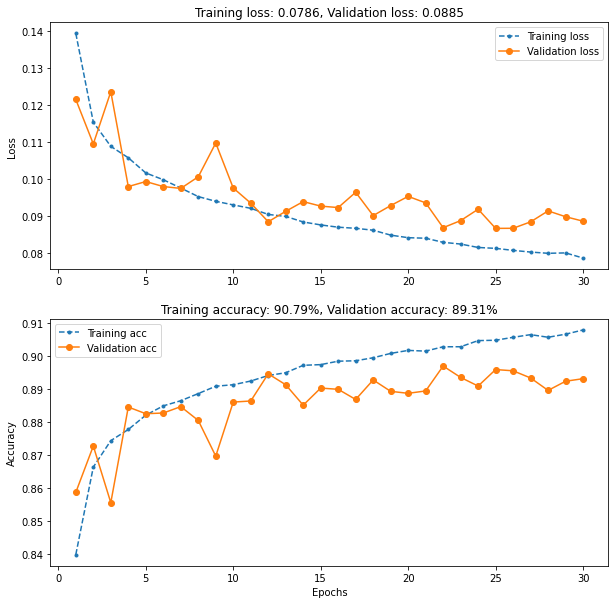

In [ ]:
plot_loss_acc(history)

In [30]:
path = "C:/Users/Lenovo/Documents/Paul/Travail/ENSEIRB-MATMECA/3A/Alpha-Go/alpha-go-like/priors/"
model_prior.save('model_prior')

model_prior_json = model_prior.to_json()
with open("model_prior.json", "w") as json_file:
    json_file.write(model_prior_json)
# serialize weights to HDF5
model_prior.save_weights("model_prior.h5")
print("Saved model to disk")

INFO:tensorflow:Assets written to: model_prior/assets
Saved model to disk


In [ ]:
def position_predict(black_stones, white_stones):

    X = np.zeros([1, board_size, board_size, 2], dtype = int)

    # Construction du board
    for white in white_stones:
        (col, lin) = name_to_coord(white)
        X[0][col][lin][1] = 1    
    for black in black_stones:
        (col, lin) = name_to_coord(black)
        X[0][col][lin][0] = 1

    prediction = model_prior.predict(X)
    
    return prediction

In [ ]:
# Par exemple, nous pourrons appeler votre prédiction ainsi
print("Prediction this sample:")
P = np.random.randint(0, len(data))
prediction = position_predict(data[P]["black_stones"], data[P]["white_stones"])
reality = [data[P]["black_wins"]/data[P]["rollouts"], data[P]["white_wins"]/data[P]["rollouts"]]
print(f"For sample {P} you predicted {prediction} and the actual target was {reality}")

Prediction this sample:
For sample 15564 you predicted [[0.88326585 0.11933982]] and the actual target was [0.96, 0.04]


<font color="lightblue">

Il nous suffit maintenant d'appeler la fonction ```position_predict()``` pour calculer les prédictions des probabilités de victoire pour le joueur noir et le joueur blanc.

Le code suivant permettant de prédire les probabilités de victoire sur le jeu de données de base mais il est commenté car il est très long à exécuter et les résultats sont présentés par la suite.

</font>

# Prédictions des données

In [ ]:
# Importer les données à tester
# ------------ CHANGER ICI LES URLS -----------------
data_url = "https://www.labri.fr/perso/lsimon/ia-inge2/positions-to-evaluate-9x9.json.gz"
data_to_predict = "to_predict.json.gz"

data_url_results = "https://www.labri.fr/perso/lsimon/ia-inge2/positions-to-evaluate-9x9-attempt.results.txt"
data_results = "results.txt"

to_predict = get_raw_data_go(data_url,data_to_predict)

'''
download(data_url_results,data_results)
# Récuperer les résults
with open("results.txt") as f:
    txt = f.readlines()
results = [float(x.strip()) for x in txt]
'''

File to_predict.json.gz not found, I am downloading it... Done


'\ndownload(data_url_results,data_results)\n# Récuperer les résults\nwith open("results.txt") as f:\n    txt = f.readlines()\nresults = [float(x.strip()) for x in txt]\n'

<font color="lightblue">

Nous pouvons maintenant écrire nos prédictions des nouvelles données dans ```my_predictions.txt```.

</font>

In [ ]:
# Prediction des données
predictions = np.empty(len(to_predict))

# Remplissage du tableau de prédictions
for t in range(len(to_predict)):
  # Comme nous souhaitons seulement les prédictions sur le % de victoire pour le joueur noir, on prend la première composante
  predictions[t] = position_predict(to_predict[t]['black_stones'], to_predict[t]['white_stones'])[0][0]

In [31]:
with open("my_predictions.txt", "w") as f:
     for p in predictions:
        f.write(str(p)+"\n")
print("Predictions saved")

Predictions saved
